In [1]:
from finta import TA
import yfinance as yf
import numpy as np
import pandas as pd
import yfinance as yf
from alpha_vantage.timeseries import TimeSeries
import datetime as dt
import copy
import matplotlib.pyplot as plt
import time
import json



In [2]:
from smartapi import SmartConnect 
obj=SmartConnect(api_key="iJ3YYOXH")
data = obj.generateSession("S776051","Madhya246###")
refreshToken= data['data']['refreshToken']
feedToken=obj.getfeedToken()
userProfile= obj.getProfile(refreshToken)


In [3]:
tickers=["3045"]

In [4]:
ohlc_intraday={}

In [5]:
for ticker in tickers:
    ohlc_intraday[ticker]=pd.DataFrame()

    historicParam={
    "exchange": "NSE",
    "symboltoken": ticker,
    "interval": "FIVE_MINUTE",
    "fromdate": "2021-04-08 09:15", 
    "todate": "2021-08-14 15:25"
    }

    data=obj.getCandleData(historicParam)

    data=pd.DataFrame(data)["data"]
    open=[]
    close=[]
    high=[]
    low=[]
    volume=[]
    index=[]
    for i in range(len(data)):
        open.append(data[i][1])

    for i in range(len(data)):
        close.append(data[i][4])

    for i in range(len(data)):
        high.append(data[i][2])

    for i in range(len(data)):
        low.append(data[i][3])

    for i in range(len(data)):
        index.append(data[i][0])

    for i in range(len(data)):
        volume.append(data[i][5])


    ohlc_intraday[ticker]["Index"]=np.array(index)
    ohlc_intraday[ticker]["Open"]=np.array(open)
    ohlc_intraday[ticker]["High"]=np.array(high)
    ohlc_intraday[ticker]["Low"]=np.array(low)

    ohlc_intraday[ticker]["Close"]=np.array(close)
    ohlc_intraday[ticker]["Volume"]=np.array(volume)
    ohlc_intraday[ticker].set_index("Index",inplace=True)


In [6]:
data

Series([], Name: data, dtype: float64)

In [7]:
ohlc_intraday

{'SBIN-EQ': Empty DataFrame
 Columns: [Open, High, Low, Close, Volume]
 Index: []}

In [8]:
ohlc_dict={}
ohlc_dict=copy.deepcopy(ohlc_intraday)

In [9]:
def MACD(DF,a,b,c):
    """function to calculate MACD
       typical values a = 12; b =26, c =9"""
    df = DF.copy()
    df["MA_Fast"]=df["close"].ewm(span=a,min_periods=a).mean()
    df["MA_Slow"]=df["close"].ewm(span=b,min_periods=b).mean()
    df["MACD"]=df["MA_Fast"]-df["MA_Slow"]
    df["Signal"]=df["MACD"].ewm(span=c,min_periods=c).mean()
    
    df.drop(["MA_Fast","MA_Slow"],axis=1)
    return df


def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/(252*74)
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252*74)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

def win_pct(DF):
    df=DF.copy()
    j=0
    for i in range(len(df)):
        if df["profit"][i]>0:
            j+=1

    win_percent=j/len(df)*100

    return win_percent
            


In [10]:
tickers_signal = {}
ticker_ret = {}

In [11]:
for ticker in tickers:
    ohlc_dict
    ohlc_dict[ticker]=ohlc_dict[ticker].iloc[:,[0,1,2,3,4]]
    ohlc_dict[ticker].columns=["open","high","low","close","volume"]
    ohlc_dict[ticker]["fisher 20"]=TA.FISH(ohlc_dict[ticker],20)
    ohlc_dict[ticker]["fisher 10"]=TA.FISH(ohlc_dict[ticker],10)    
    ohlc_dict[ticker]["RSI 16"]=TA.RSI(ohlc_dict[ticker],16)
    ohlc_dict[ticker]["RSI 21"]=TA.RSI(ohlc_dict[ticker],21)
    ohlc_dict[ticker]["MACD macd line"]=MACD(ohlc_dict[ticker],12,26,9)["MACD"]
    ohlc_dict[ticker]["MACD signal line"]=MACD(ohlc_dict[ticker],12,26,9)["Signal"]
    
   
    

In [12]:
ticker_signal={}
ticker_ret={}
ohlc_database={}
price_in=[]
price_out=[]
order=[]
stock=[]


In [13]:
for ticker in tickers:
    ticker_signal[ticker]=[]
    ticker_ret[ticker]=[]
    ohlc_database[ticker]=pd.DataFrame()

    ohlc_dict[ticker].rename(columns={"open":"Open","high":"High","low":"Low","close":"Close","volume":"Volume"},inplace=True)
    
for ticker in tickers:
    signal=""
    for i in range(len(ohlc_dict[ticker])):
        if signal=="":
            if ohlc_dict[ticker]["fisher 10"][i]>0 and ohlc_dict[ticker]["fisher 10"][i-1]<0 and ohlc_dict[ticker]["RSI 16"][i]>50: 
                signal="buy"
                price=ohlc_dict[ticker]["Close"][i]
                price_in.append(ohlc_dict[ticker]["Close"][i])
                
                order.append("long")
                stock.append(ticker)

                
               



            elif (ohlc_dict[ticker]["fisher 20"][i]<0 and ohlc_dict[ticker]["fisher 20"][i-1]>0) and ohlc_dict[ticker]["MACD macd line"][i]<ohlc_dict[ticker]["MACD signal line"][i] and ohlc_dict[ticker]["RSI 21"][i]<42.5:
                signal="sell"
                price=ohlc_dict[ticker]["Close"][i]
                
                price_in.append(ohlc_dict[ticker]["Close"][i])
                
                order.append("short")
                stock.append(ticker)                
            ticker_ret[ticker].append(0)

        elif signal=="buy":
            if (ohlc_dict[ticker]["fisher 20"][i]<0.5 and ohlc_dict[ticker]["fisher 20"][i-1]>0.5) or ohlc_dict[ticker]["Close"][i]>=price+.02*price or ohlc_dict[ticker]["Close"][i]<=price-.008*price:

                signal=""
                price_out.append(ohlc_dict[ticker]["Close"][i])
                ticker_ret[ticker].append((ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)

            
            
            else:
                ticker_ret[ticker].append((ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)
           
        
        
        elif signal=="sell":
            if (ohlc_dict[ticker]["fisher 20"][i]>-1 and ohlc_dict[ticker]["fisher 20"][i-1]<-1) or (ohlc_dict[ticker]["fisher 20"][i]>0 and ohlc_dict[ticker]["fisher 20"][i-1]<0) or ohlc_dict[ticker]["Close"][i]<=price +.02*price or ohlc_dict[ticker]["Close"][i]>=price-.005*price:
                price_out.append(ohlc_dict[ticker]["Close"][i])

                signal=""
                ticker_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)

          
            
            else:
                ticker_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)
    if len(price_in)!=len(price_out):
        price_out.append(ohlc_dict[ticker]["Close"][-1])
    ohlc_dict[ticker]["ret"] = np.array(ticker_ret[ticker])    

In [14]:
ohlcv_database=pd.DataFrame()

ohlcv_database["price_in"]=np.array(price_in)
ohlcv_database["price_out"]=np.array(price_out)
ohlcv_database["order"]=np.array(order)
ohlcv_database["stock"]=np.array(stock)

In [15]:
profit=[]
for i in range(len(ohlcv_database)):
    if ohlcv_database["order"][i]=="long":
        profit.append(((ohlcv_database["price_out"][i]-ohlcv_database["price_in"][i])/ohlcv_database["price_in"][i])*100)

    elif ohlcv_database["order"][i]=="short":
        profit.append(((ohlcv_database["price_in"][i]-ohlcv_database["price_out"][i])/ohlcv_database["price_out"][i])*100)

ohlcv_database["profit"]=np.array(profit)

In [16]:
ohlcv_database

,price_in,price_out,order,stock,profit


In [17]:
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_dict[ticker]["ret"]
strategy_df["ret"] = strategy_df.mean(axis=1)
CAGR(strategy_df)



IndexError: list index out of range

<AxesSubplot:xlabel='Index'>

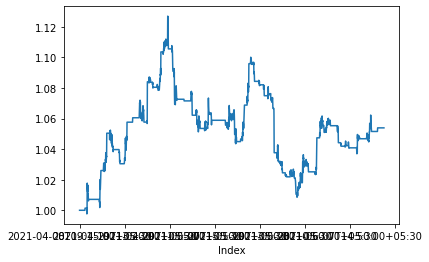

In [ ]:
(1+strategy_df["ret"]).cumprod().plot()

In [ ]:
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
win_pcts={}
for ticker in tickers:
    win=[]
    print("calculating KPIs for ",ticker)      
    cagr[ticker] =  CAGR(ohlc_dict[ticker])
    for i in range(len(ohlcv_database)):
        if ohlcv_database["stock"][i]==ticker:
            
            win.append(ohlcv_database["profit"][i])
    win_df=pd.DataFrame()
    win_df["profit"]=np.array(win)
    win_pcts[ticker]=win_pct(win_df)           

    sharpe_ratios[ticker] =  sharpe(ohlc_dict[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_dict[ticker])

KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown,win_pcts],index=["Return","Sharpe Ratio","Max Drawdown","win_pct"])      
KPI_df.T


calculating KPIs for  3045


,Return,Sharpe Ratio,Max Drawdown,win_pct
3045,0.33604,1.670097,0.105089,42.857143


In [18]:
import yfinance as yf
data=yf.download('MSFT',period='5d',interval='5m')